In [1]:
import torch
from torch import nn
import time
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue

In [2]:
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [3]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


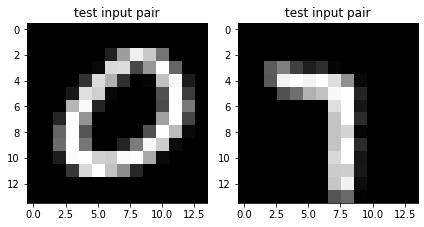

The test classes are: 0 and 7.
The test target is: 0


In [4]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [5]:
# prepocess the training and testing data
tran_train_input=train_input.view([2000, 1, 14, 14])
tran_train_classes=train_classes.view([2000])
tran_test_input=test_input.view([2000, 1, 14, 14])
tran_test_classes=test_classes.view([2000])

In [6]:
#CNN
class CNN_one_by_one_Net(nn.Module):
    def __init__(self):
        super(CNN_one_by_one_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return x

        # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #set gradients to zero
                loss.backward()                                #backpropagate
                self.optimizer.step()
#                 Every 50 data, output loss once
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def compare_two_digit(self, input_data, comp_targets):
        
        #test mode
        self.eval() 
        errors = 0
        for pairs,comp_target in zip(input_data, comp_targets):
            input_num1=pairs[0].view([1,1,14,14])
            input_num2=pairs[1].view([1,1,14,14])
            output_1 = self(input_num1)
            output_2 = self(input_num2)
            _, predicted_1 = torch.max(output_1, 1)   #return value and key
            _, predicted_2 = torch.max(output_2, 1)   #return value and key
            if(predicted_2-predicted_1>0):
                result=1
            else:
                result=0
            if(comp_target!=result):
                errors=errors+1
        return float(errors)/input_data.size(0)
        
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [7]:
my_model = CNN_one_by_one_Net()
my_model.save_model('CNN_one_by_one.pth')

In [8]:
# train the model
my_model.trainer(tran_train_input, tran_train_classes)

Epoch: 001/025 | Batch 000/2000 | Loss: 19.450377
Epoch: 001/025 | Batch 050/2000 | Loss: 15.760029
Epoch: 001/025 | Batch 100/2000 | Loss: 10.758293
Epoch: 001/025 | Batch 150/2000 | Loss: 7.322582
Epoch: 001/025 | Batch 200/2000 | Loss: 4.898264
Epoch: 001/025 | Batch 250/2000 | Loss: 4.096121
Epoch: 001/025 | Batch 300/2000 | Loss: 2.878542
Epoch: 001/025 | Batch 350/2000 | Loss: 2.771480
Epoch: 001/025 | Batch 400/2000 | Loss: 2.554552
Epoch: 001/025 | Batch 450/2000 | Loss: 1.957769
Epoch: 001/025 | Batch 500/2000 | Loss: 2.380977
Epoch: 001/025 | Batch 550/2000 | Loss: 2.100729
Epoch: 001/025 | Batch 600/2000 | Loss: 2.144961
Epoch: 001/025 | Batch 650/2000 | Loss: 1.777734
Epoch: 001/025 | Batch 700/2000 | Loss: 2.021037
Epoch: 001/025 | Batch 750/2000 | Loss: 1.794468
Epoch: 001/025 | Batch 800/2000 | Loss: 1.911304
Epoch: 001/025 | Batch 850/2000 | Loss: 1.879848
Epoch: 001/025 | Batch 900/2000 | Loss: 1.348127
Epoch: 001/025 | Batch 950/2000 | Loss: 1.649411
Epoch: 001/025 | 

Epoch: 005/025 | Batch 900/2000 | Loss: 0.304367
Epoch: 005/025 | Batch 950/2000 | Loss: 0.377189
Epoch: 005/025 | Batch 1000/2000 | Loss: 0.175344
Epoch: 005/025 | Batch 1050/2000 | Loss: 0.224621
Epoch: 005/025 | Batch 1100/2000 | Loss: 0.677633
Epoch: 005/025 | Batch 1150/2000 | Loss: 0.266494
Epoch: 005/025 | Batch 1200/2000 | Loss: 0.127509
Epoch: 005/025 | Batch 1250/2000 | Loss: 0.257998
Epoch: 005/025 | Batch 1300/2000 | Loss: 0.184824
Epoch: 005/025 | Batch 1350/2000 | Loss: 0.131813
Epoch: 005/025 | Batch 1400/2000 | Loss: 0.379357
Epoch: 005/025 | Batch 1450/2000 | Loss: 0.319800
Epoch: 005/025 | Batch 1500/2000 | Loss: 0.187802
Epoch: 005/025 | Batch 1550/2000 | Loss: 0.237641
Epoch: 005/025 | Batch 1600/2000 | Loss: 0.201837
Epoch: 005/025 | Batch 1650/2000 | Loss: 0.256502
Epoch: 005/025 | Batch 1700/2000 | Loss: 0.296921
Epoch: 005/025 | Batch 1750/2000 | Loss: 0.393576
Epoch: 005/025 | Batch 1800/2000 | Loss: 0.225628
Epoch: 005/025 | Batch 1850/2000 | Loss: 0.174902
Ep

Epoch: 009/025 | Batch 1900/2000 | Loss: 0.262990
Epoch: 009/025 | Batch 1950/2000 | Loss: 0.085034
Time elapsed: 0.03 min
Epoch: 010/025 | Batch 000/2000 | Loss: 0.292777
Epoch: 010/025 | Batch 050/2000 | Loss: 0.152115
Epoch: 010/025 | Batch 100/2000 | Loss: 0.085052
Epoch: 010/025 | Batch 150/2000 | Loss: 0.125275
Epoch: 010/025 | Batch 200/2000 | Loss: 0.060465
Epoch: 010/025 | Batch 250/2000 | Loss: 0.129047
Epoch: 010/025 | Batch 300/2000 | Loss: 0.118973
Epoch: 010/025 | Batch 350/2000 | Loss: 0.161102
Epoch: 010/025 | Batch 400/2000 | Loss: 0.143906
Epoch: 010/025 | Batch 450/2000 | Loss: 0.267767
Epoch: 010/025 | Batch 500/2000 | Loss: 0.102275
Epoch: 010/025 | Batch 550/2000 | Loss: 0.135051
Epoch: 010/025 | Batch 600/2000 | Loss: 0.153731
Epoch: 010/025 | Batch 650/2000 | Loss: 0.215067
Epoch: 010/025 | Batch 700/2000 | Loss: 0.343765
Epoch: 010/025 | Batch 750/2000 | Loss: 0.116285
Epoch: 010/025 | Batch 800/2000 | Loss: 0.284019
Epoch: 010/025 | Batch 850/2000 | Loss: 0.28

Epoch: 014/025 | Batch 850/2000 | Loss: 0.071030
Epoch: 014/025 | Batch 900/2000 | Loss: 0.208762
Epoch: 014/025 | Batch 950/2000 | Loss: 0.156856
Epoch: 014/025 | Batch 1000/2000 | Loss: 0.072352
Epoch: 014/025 | Batch 1050/2000 | Loss: 0.075300
Epoch: 014/025 | Batch 1100/2000 | Loss: 0.482329
Epoch: 014/025 | Batch 1150/2000 | Loss: 0.058904
Epoch: 014/025 | Batch 1200/2000 | Loss: 0.113267
Epoch: 014/025 | Batch 1250/2000 | Loss: 0.066521
Epoch: 014/025 | Batch 1300/2000 | Loss: 0.113925
Epoch: 014/025 | Batch 1350/2000 | Loss: 0.069703
Epoch: 014/025 | Batch 1400/2000 | Loss: 0.009644
Epoch: 014/025 | Batch 1450/2000 | Loss: 0.022990
Epoch: 014/025 | Batch 1500/2000 | Loss: 0.063331
Epoch: 014/025 | Batch 1550/2000 | Loss: 0.045527
Epoch: 014/025 | Batch 1600/2000 | Loss: 0.053003
Epoch: 014/025 | Batch 1650/2000 | Loss: 0.045066
Epoch: 014/025 | Batch 1700/2000 | Loss: 0.427203
Epoch: 014/025 | Batch 1750/2000 | Loss: 0.088868
Epoch: 014/025 | Batch 1800/2000 | Loss: 0.066473
Epo

Epoch: 019/025 | Batch 050/2000 | Loss: 0.106065
Epoch: 019/025 | Batch 100/2000 | Loss: 0.003220
Epoch: 019/025 | Batch 150/2000 | Loss: 0.017651
Epoch: 019/025 | Batch 200/2000 | Loss: 0.040945
Epoch: 019/025 | Batch 250/2000 | Loss: 0.066835
Epoch: 019/025 | Batch 300/2000 | Loss: 0.099370
Epoch: 019/025 | Batch 350/2000 | Loss: 0.102242
Epoch: 019/025 | Batch 400/2000 | Loss: 0.054814
Epoch: 019/025 | Batch 450/2000 | Loss: 0.158319
Epoch: 019/025 | Batch 500/2000 | Loss: 0.009203
Epoch: 019/025 | Batch 550/2000 | Loss: 0.020688
Epoch: 019/025 | Batch 600/2000 | Loss: 0.125865
Epoch: 019/025 | Batch 650/2000 | Loss: 0.051985
Epoch: 019/025 | Batch 700/2000 | Loss: 0.084749
Epoch: 019/025 | Batch 750/2000 | Loss: 0.023407
Epoch: 019/025 | Batch 800/2000 | Loss: 0.073443
Epoch: 019/025 | Batch 850/2000 | Loss: 0.035403
Epoch: 019/025 | Batch 900/2000 | Loss: 0.032529
Epoch: 019/025 | Batch 950/2000 | Loss: 0.150402
Epoch: 019/025 | Batch 1000/2000 | Loss: 0.154434
Epoch: 019/025 | Ba

Epoch: 023/025 | Batch 600/2000 | Loss: 0.041050
Epoch: 023/025 | Batch 650/2000 | Loss: 0.199502
Epoch: 023/025 | Batch 700/2000 | Loss: 0.016820
Epoch: 023/025 | Batch 750/2000 | Loss: 0.022420
Epoch: 023/025 | Batch 800/2000 | Loss: 0.070412
Epoch: 023/025 | Batch 850/2000 | Loss: 0.041952
Epoch: 023/025 | Batch 900/2000 | Loss: 0.204770
Epoch: 023/025 | Batch 950/2000 | Loss: 0.049606
Epoch: 023/025 | Batch 1000/2000 | Loss: 0.129776
Epoch: 023/025 | Batch 1050/2000 | Loss: 0.011826
Epoch: 023/025 | Batch 1100/2000 | Loss: 0.066570
Epoch: 023/025 | Batch 1150/2000 | Loss: 0.039970
Epoch: 023/025 | Batch 1200/2000 | Loss: 0.011941
Epoch: 023/025 | Batch 1250/2000 | Loss: 0.094535
Epoch: 023/025 | Batch 1300/2000 | Loss: 0.075990
Epoch: 023/025 | Batch 1350/2000 | Loss: 0.029513
Epoch: 023/025 | Batch 1400/2000 | Loss: 0.061139
Epoch: 023/025 | Batch 1450/2000 | Loss: 0.104839
Epoch: 023/025 | Batch 1500/2000 | Loss: 0.002583
Epoch: 023/025 | Batch 1550/2000 | Loss: 0.037886
Epoch: 0

In [9]:
# output the number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 43274


Now, we have trained a model to figure out what a number is, then I can apply this model to compare the number pairs.

The advantage of this method is we can split the 1000 pairs of data into 2000 data. Written digital number recognition has acquired very high accuracy, so we are going to firstly recognize the numbers and then then compare them. Finally, we compare the results with the targets.

In [10]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_one_by_one_Net()
    # train the model
    my_model.trainer(tran_train_input, tran_train_classes)
    train_errors.append(my_model.compare_two_digit(train_input,train_target))
    test_errors.append(my_model.compare_two_digit(test_input,test_target))

Epoch: 001/025 | Batch 000/2000 | Loss: 21.825628
Epoch: 001/025 | Batch 050/2000 | Loss: 22.112907
Epoch: 001/025 | Batch 100/2000 | Loss: 16.284552
Epoch: 001/025 | Batch 150/2000 | Loss: 10.916778
Epoch: 001/025 | Batch 200/2000 | Loss: 7.232904
Epoch: 001/025 | Batch 250/2000 | Loss: 4.805235
Epoch: 001/025 | Batch 300/2000 | Loss: 4.552352
Epoch: 001/025 | Batch 350/2000 | Loss: 3.376638
Epoch: 001/025 | Batch 400/2000 | Loss: 2.921065
Epoch: 001/025 | Batch 450/2000 | Loss: 2.050789
Epoch: 001/025 | Batch 500/2000 | Loss: 1.889094
Epoch: 001/025 | Batch 550/2000 | Loss: 1.906738
Epoch: 001/025 | Batch 600/2000 | Loss: 2.028560
Epoch: 001/025 | Batch 650/2000 | Loss: 2.125612
Epoch: 001/025 | Batch 700/2000 | Loss: 1.822427
Epoch: 001/025 | Batch 750/2000 | Loss: 1.997752
Epoch: 001/025 | Batch 800/2000 | Loss: 2.063593
Epoch: 001/025 | Batch 850/2000 | Loss: 1.775788
Epoch: 001/025 | Batch 900/2000 | Loss: 1.737112
Epoch: 001/025 | Batch 950/2000 | Loss: 1.528988
Epoch: 001/025 |

Epoch: 005/025 | Batch 1150/2000 | Loss: 0.161161
Epoch: 005/025 | Batch 1200/2000 | Loss: 0.354623
Epoch: 005/025 | Batch 1250/2000 | Loss: 0.399845
Epoch: 005/025 | Batch 1300/2000 | Loss: 0.337526
Epoch: 005/025 | Batch 1350/2000 | Loss: 0.273967
Epoch: 005/025 | Batch 1400/2000 | Loss: 0.227674
Epoch: 005/025 | Batch 1450/2000 | Loss: 0.591681
Epoch: 005/025 | Batch 1500/2000 | Loss: 0.225626
Epoch: 005/025 | Batch 1550/2000 | Loss: 0.651346
Epoch: 005/025 | Batch 1600/2000 | Loss: 0.188921
Epoch: 005/025 | Batch 1650/2000 | Loss: 0.385515
Epoch: 005/025 | Batch 1700/2000 | Loss: 0.640625
Epoch: 005/025 | Batch 1750/2000 | Loss: 0.342519
Epoch: 005/025 | Batch 1800/2000 | Loss: 0.429056
Epoch: 005/025 | Batch 1850/2000 | Loss: 0.395310
Epoch: 005/025 | Batch 1900/2000 | Loss: 0.409390
Epoch: 005/025 | Batch 1950/2000 | Loss: 0.436254
Time elapsed: 0.02 min
Epoch: 006/025 | Batch 000/2000 | Loss: 0.393845
Epoch: 006/025 | Batch 050/2000 | Loss: 0.381142
Epoch: 006/025 | Batch 100/20

Epoch: 010/025 | Batch 050/2000 | Loss: 0.143376
Epoch: 010/025 | Batch 100/2000 | Loss: 0.183563
Epoch: 010/025 | Batch 150/2000 | Loss: 0.278956
Epoch: 010/025 | Batch 200/2000 | Loss: 0.110140
Epoch: 010/025 | Batch 250/2000 | Loss: 0.131217
Epoch: 010/025 | Batch 300/2000 | Loss: 0.172248
Epoch: 010/025 | Batch 350/2000 | Loss: 0.124854
Epoch: 010/025 | Batch 400/2000 | Loss: 0.173253
Epoch: 010/025 | Batch 450/2000 | Loss: 0.141533
Epoch: 010/025 | Batch 500/2000 | Loss: 0.278949
Epoch: 010/025 | Batch 550/2000 | Loss: 0.301348
Epoch: 010/025 | Batch 600/2000 | Loss: 0.147594
Epoch: 010/025 | Batch 650/2000 | Loss: 0.354051
Epoch: 010/025 | Batch 700/2000 | Loss: 0.417196
Epoch: 010/025 | Batch 750/2000 | Loss: 0.155969
Epoch: 010/025 | Batch 800/2000 | Loss: 0.288358
Epoch: 010/025 | Batch 850/2000 | Loss: 0.184332
Epoch: 010/025 | Batch 900/2000 | Loss: 0.189103
Epoch: 010/025 | Batch 950/2000 | Loss: 0.204947
Epoch: 010/025 | Batch 1000/2000 | Loss: 0.185006
Epoch: 010/025 | Ba

Epoch: 014/025 | Batch 1250/2000 | Loss: 0.158367
Epoch: 014/025 | Batch 1300/2000 | Loss: 0.026933
Epoch: 014/025 | Batch 1350/2000 | Loss: 0.030053
Epoch: 014/025 | Batch 1400/2000 | Loss: 0.082353
Epoch: 014/025 | Batch 1450/2000 | Loss: 0.068739
Epoch: 014/025 | Batch 1500/2000 | Loss: 0.125741
Epoch: 014/025 | Batch 1550/2000 | Loss: 0.108962
Epoch: 014/025 | Batch 1600/2000 | Loss: 0.328729
Epoch: 014/025 | Batch 1650/2000 | Loss: 0.143362
Epoch: 014/025 | Batch 1700/2000 | Loss: 0.268107
Epoch: 014/025 | Batch 1750/2000 | Loss: 0.047196
Epoch: 014/025 | Batch 1800/2000 | Loss: 0.171436
Epoch: 014/025 | Batch 1850/2000 | Loss: 0.112672
Epoch: 014/025 | Batch 1900/2000 | Loss: 0.143809
Epoch: 014/025 | Batch 1950/2000 | Loss: 0.132411
Time elapsed: 0.05 min
Epoch: 015/025 | Batch 000/2000 | Loss: 0.178525
Epoch: 015/025 | Batch 050/2000 | Loss: 0.070751
Epoch: 015/025 | Batch 100/2000 | Loss: 0.079450
Epoch: 015/025 | Batch 150/2000 | Loss: 0.116811
Epoch: 015/025 | Batch 200/2000

Epoch: 019/025 | Batch 450/2000 | Loss: 0.029471
Epoch: 019/025 | Batch 500/2000 | Loss: 0.167948
Epoch: 019/025 | Batch 550/2000 | Loss: 0.078962
Epoch: 019/025 | Batch 600/2000 | Loss: 0.104711
Epoch: 019/025 | Batch 650/2000 | Loss: 0.192620
Epoch: 019/025 | Batch 700/2000 | Loss: 0.199960
Epoch: 019/025 | Batch 750/2000 | Loss: 0.075004
Epoch: 019/025 | Batch 800/2000 | Loss: 0.194584
Epoch: 019/025 | Batch 850/2000 | Loss: 0.121201
Epoch: 019/025 | Batch 900/2000 | Loss: 0.084317
Epoch: 019/025 | Batch 950/2000 | Loss: 0.204705
Epoch: 019/025 | Batch 1000/2000 | Loss: 0.019101
Epoch: 019/025 | Batch 1050/2000 | Loss: 0.067297
Epoch: 019/025 | Batch 1100/2000 | Loss: 0.163327
Epoch: 019/025 | Batch 1150/2000 | Loss: 0.068602
Epoch: 019/025 | Batch 1200/2000 | Loss: 0.221880
Epoch: 019/025 | Batch 1250/2000 | Loss: 0.023869
Epoch: 019/025 | Batch 1300/2000 | Loss: 0.215813
Epoch: 019/025 | Batch 1350/2000 | Loss: 0.042333
Epoch: 019/025 | Batch 1400/2000 | Loss: 0.050397
Epoch: 019/

Epoch: 023/025 | Batch 1100/2000 | Loss: 0.094504
Epoch: 023/025 | Batch 1150/2000 | Loss: 0.013153
Epoch: 023/025 | Batch 1200/2000 | Loss: 0.029807
Epoch: 023/025 | Batch 1250/2000 | Loss: 0.040371
Epoch: 023/025 | Batch 1300/2000 | Loss: 0.104745
Epoch: 023/025 | Batch 1350/2000 | Loss: 0.000713
Epoch: 023/025 | Batch 1400/2000 | Loss: 0.035756
Epoch: 023/025 | Batch 1450/2000 | Loss: 0.116260
Epoch: 023/025 | Batch 1500/2000 | Loss: 0.057577
Epoch: 023/025 | Batch 1550/2000 | Loss: 0.048137
Epoch: 023/025 | Batch 1600/2000 | Loss: 0.011186
Epoch: 023/025 | Batch 1650/2000 | Loss: 0.014311
Epoch: 023/025 | Batch 1700/2000 | Loss: 0.046283
Epoch: 023/025 | Batch 1750/2000 | Loss: 0.182180
Epoch: 023/025 | Batch 1800/2000 | Loss: 0.078394
Epoch: 023/025 | Batch 1850/2000 | Loss: 0.023821
Epoch: 023/025 | Batch 1900/2000 | Loss: 0.058874
Epoch: 023/025 | Batch 1950/2000 | Loss: 0.120376
Time elapsed: 0.09 min
Epoch: 024/025 | Batch 000/2000 | Loss: 0.158140
Epoch: 024/025 | Batch 050/2

Epoch: 002/025 | Batch 1500/2000 | Loss: 1.231981
Epoch: 002/025 | Batch 1550/2000 | Loss: 1.324412
Epoch: 002/025 | Batch 1600/2000 | Loss: 1.139423
Epoch: 002/025 | Batch 1650/2000 | Loss: 1.021875
Epoch: 002/025 | Batch 1700/2000 | Loss: 1.106250
Epoch: 002/025 | Batch 1750/2000 | Loss: 1.146895
Epoch: 002/025 | Batch 1800/2000 | Loss: 1.069143
Epoch: 002/025 | Batch 1850/2000 | Loss: 0.931800
Epoch: 002/025 | Batch 1900/2000 | Loss: 1.019877
Epoch: 002/025 | Batch 1950/2000 | Loss: 1.095333
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/2000 | Loss: 1.112282
Epoch: 003/025 | Batch 050/2000 | Loss: 1.212196
Epoch: 003/025 | Batch 100/2000 | Loss: 1.092135
Epoch: 003/025 | Batch 150/2000 | Loss: 0.893087
Epoch: 003/025 | Batch 200/2000 | Loss: 1.273135
Epoch: 003/025 | Batch 250/2000 | Loss: 1.068346
Epoch: 003/025 | Batch 300/2000 | Loss: 0.900588
Epoch: 003/025 | Batch 350/2000 | Loss: 1.108667
Epoch: 003/025 | Batch 400/2000 | Loss: 0.863482
Epoch: 003/025 | Batch 450/2000 | Lo

Epoch: 007/025 | Batch 300/2000 | Loss: 0.298834
Epoch: 007/025 | Batch 350/2000 | Loss: 0.371952
Epoch: 007/025 | Batch 400/2000 | Loss: 0.386345
Epoch: 007/025 | Batch 450/2000 | Loss: 0.501741
Epoch: 007/025 | Batch 500/2000 | Loss: 0.238444
Epoch: 007/025 | Batch 550/2000 | Loss: 0.269448
Epoch: 007/025 | Batch 600/2000 | Loss: 0.284543
Epoch: 007/025 | Batch 650/2000 | Loss: 0.517184
Epoch: 007/025 | Batch 700/2000 | Loss: 0.297257
Epoch: 007/025 | Batch 750/2000 | Loss: 0.281311
Epoch: 007/025 | Batch 800/2000 | Loss: 0.519467
Epoch: 007/025 | Batch 850/2000 | Loss: 0.559020
Epoch: 007/025 | Batch 900/2000 | Loss: 0.489365
Epoch: 007/025 | Batch 950/2000 | Loss: 0.445256
Epoch: 007/025 | Batch 1000/2000 | Loss: 0.295234
Epoch: 007/025 | Batch 1050/2000 | Loss: 0.310159
Epoch: 007/025 | Batch 1100/2000 | Loss: 0.493993
Epoch: 007/025 | Batch 1150/2000 | Loss: 0.218344
Epoch: 007/025 | Batch 1200/2000 | Loss: 0.173870
Epoch: 007/025 | Batch 1250/2000 | Loss: 0.379208
Epoch: 007/025

Epoch: 011/025 | Batch 1450/2000 | Loss: 0.378291
Epoch: 011/025 | Batch 1500/2000 | Loss: 0.148385
Epoch: 011/025 | Batch 1550/2000 | Loss: 0.160783
Epoch: 011/025 | Batch 1600/2000 | Loss: 0.109387
Epoch: 011/025 | Batch 1650/2000 | Loss: 0.201062
Epoch: 011/025 | Batch 1700/2000 | Loss: 0.256466
Epoch: 011/025 | Batch 1750/2000 | Loss: 0.156341
Epoch: 011/025 | Batch 1800/2000 | Loss: 0.388086
Epoch: 011/025 | Batch 1850/2000 | Loss: 0.138102
Epoch: 011/025 | Batch 1900/2000 | Loss: 0.247150
Epoch: 011/025 | Batch 1950/2000 | Loss: 0.167493
Time elapsed: 0.05 min
Epoch: 012/025 | Batch 000/2000 | Loss: 0.089720
Epoch: 012/025 | Batch 050/2000 | Loss: 0.146193
Epoch: 012/025 | Batch 100/2000 | Loss: 0.067881
Epoch: 012/025 | Batch 150/2000 | Loss: 0.071126
Epoch: 012/025 | Batch 200/2000 | Loss: 0.253165
Epoch: 012/025 | Batch 250/2000 | Loss: 0.223093
Epoch: 012/025 | Batch 300/2000 | Loss: 0.247753
Epoch: 012/025 | Batch 350/2000 | Loss: 0.201024
Epoch: 012/025 | Batch 400/2000 | L

Epoch: 016/025 | Batch 100/2000 | Loss: 0.181591
Epoch: 016/025 | Batch 150/2000 | Loss: 0.170452
Epoch: 016/025 | Batch 200/2000 | Loss: 0.177158
Epoch: 016/025 | Batch 250/2000 | Loss: 0.058165
Epoch: 016/025 | Batch 300/2000 | Loss: 0.147094
Epoch: 016/025 | Batch 350/2000 | Loss: 0.142151
Epoch: 016/025 | Batch 400/2000 | Loss: 0.070160
Epoch: 016/025 | Batch 450/2000 | Loss: 0.056672
Epoch: 016/025 | Batch 500/2000 | Loss: 0.060614
Epoch: 016/025 | Batch 550/2000 | Loss: 0.116724
Epoch: 016/025 | Batch 600/2000 | Loss: 0.051518
Epoch: 016/025 | Batch 650/2000 | Loss: 0.316375
Epoch: 016/025 | Batch 700/2000 | Loss: 0.054531
Epoch: 016/025 | Batch 750/2000 | Loss: 0.049741
Epoch: 016/025 | Batch 800/2000 | Loss: 0.233130
Epoch: 016/025 | Batch 850/2000 | Loss: 0.198421
Epoch: 016/025 | Batch 900/2000 | Loss: 0.186668
Epoch: 016/025 | Batch 950/2000 | Loss: 0.091153
Epoch: 016/025 | Batch 1000/2000 | Loss: 0.088649
Epoch: 016/025 | Batch 1050/2000 | Loss: 0.034579
Epoch: 016/025 | B

Epoch: 020/025 | Batch 1050/2000 | Loss: 0.077923
Epoch: 020/025 | Batch 1100/2000 | Loss: 0.191895
Epoch: 020/025 | Batch 1150/2000 | Loss: 0.102295
Epoch: 020/025 | Batch 1200/2000 | Loss: 0.016067
Epoch: 020/025 | Batch 1250/2000 | Loss: 0.125033
Epoch: 020/025 | Batch 1300/2000 | Loss: 0.048284
Epoch: 020/025 | Batch 1350/2000 | Loss: 0.054934
Epoch: 020/025 | Batch 1400/2000 | Loss: 0.126937
Epoch: 020/025 | Batch 1450/2000 | Loss: 0.036209
Epoch: 020/025 | Batch 1500/2000 | Loss: 0.020830
Epoch: 020/025 | Batch 1550/2000 | Loss: 0.029430
Epoch: 020/025 | Batch 1600/2000 | Loss: 0.202227
Epoch: 020/025 | Batch 1650/2000 | Loss: 0.034798
Epoch: 020/025 | Batch 1700/2000 | Loss: 0.101367
Epoch: 020/025 | Batch 1750/2000 | Loss: 0.164231
Epoch: 020/025 | Batch 1800/2000 | Loss: 0.083020
Epoch: 020/025 | Batch 1850/2000 | Loss: 0.029261
Epoch: 020/025 | Batch 1900/2000 | Loss: 0.070072
Epoch: 020/025 | Batch 1950/2000 | Loss: 0.100429
Time elapsed: 0.08 min
Epoch: 021/025 | Batch 000/

Epoch: 025/025 | Batch 850/2000 | Loss: 0.060332
Epoch: 025/025 | Batch 900/2000 | Loss: 0.074278
Epoch: 025/025 | Batch 950/2000 | Loss: 0.038776
Epoch: 025/025 | Batch 1000/2000 | Loss: 0.022563
Epoch: 025/025 | Batch 1050/2000 | Loss: 0.053638
Epoch: 025/025 | Batch 1100/2000 | Loss: 0.068315
Epoch: 025/025 | Batch 1150/2000 | Loss: 0.048620
Epoch: 025/025 | Batch 1200/2000 | Loss: 0.020707
Epoch: 025/025 | Batch 1250/2000 | Loss: 0.095613
Epoch: 025/025 | Batch 1300/2000 | Loss: 0.054565
Epoch: 025/025 | Batch 1350/2000 | Loss: 0.012836
Epoch: 025/025 | Batch 1400/2000 | Loss: 0.034160
Epoch: 025/025 | Batch 1450/2000 | Loss: 0.206446
Epoch: 025/025 | Batch 1500/2000 | Loss: 0.013186
Epoch: 025/025 | Batch 1550/2000 | Loss: 0.208640
Epoch: 025/025 | Batch 1600/2000 | Loss: 0.255585
Epoch: 025/025 | Batch 1650/2000 | Loss: 0.046097
Epoch: 025/025 | Batch 1700/2000 | Loss: 0.063026
Epoch: 025/025 | Batch 1750/2000 | Loss: 0.064716
Epoch: 025/025 | Batch 1800/2000 | Loss: 0.011554
Epo

Epoch: 004/025 | Batch 1150/2000 | Loss: 0.276527
Epoch: 004/025 | Batch 1200/2000 | Loss: 0.301503
Epoch: 004/025 | Batch 1250/2000 | Loss: 0.412892
Epoch: 004/025 | Batch 1300/2000 | Loss: 0.385907
Epoch: 004/025 | Batch 1350/2000 | Loss: 0.333200
Epoch: 004/025 | Batch 1400/2000 | Loss: 0.600342
Epoch: 004/025 | Batch 1450/2000 | Loss: 0.389192
Epoch: 004/025 | Batch 1500/2000 | Loss: 0.242856
Epoch: 004/025 | Batch 1550/2000 | Loss: 0.469390
Epoch: 004/025 | Batch 1600/2000 | Loss: 0.345082
Epoch: 004/025 | Batch 1650/2000 | Loss: 0.576561
Epoch: 004/025 | Batch 1700/2000 | Loss: 0.561348
Epoch: 004/025 | Batch 1750/2000 | Loss: 0.527114
Epoch: 004/025 | Batch 1800/2000 | Loss: 0.336057
Epoch: 004/025 | Batch 1850/2000 | Loss: 0.320621
Epoch: 004/025 | Batch 1900/2000 | Loss: 0.461471
Epoch: 004/025 | Batch 1950/2000 | Loss: 0.534455
Time elapsed: 0.02 min
Epoch: 005/025 | Batch 000/2000 | Loss: 0.417579
Epoch: 005/025 | Batch 050/2000 | Loss: 0.504486
Epoch: 005/025 | Batch 100/20

Epoch: 009/025 | Batch 150/2000 | Loss: 0.192441
Epoch: 009/025 | Batch 200/2000 | Loss: 0.227311
Epoch: 009/025 | Batch 250/2000 | Loss: 0.343743
Epoch: 009/025 | Batch 300/2000 | Loss: 0.164811
Epoch: 009/025 | Batch 350/2000 | Loss: 0.237937
Epoch: 009/025 | Batch 400/2000 | Loss: 0.072169
Epoch: 009/025 | Batch 450/2000 | Loss: 0.272530
Epoch: 009/025 | Batch 500/2000 | Loss: 0.278823
Epoch: 009/025 | Batch 550/2000 | Loss: 0.149326
Epoch: 009/025 | Batch 600/2000 | Loss: 0.232492
Epoch: 009/025 | Batch 650/2000 | Loss: 0.337104
Epoch: 009/025 | Batch 700/2000 | Loss: 0.101029
Epoch: 009/025 | Batch 750/2000 | Loss: 0.194738
Epoch: 009/025 | Batch 800/2000 | Loss: 0.221094
Epoch: 009/025 | Batch 850/2000 | Loss: 0.141236
Epoch: 009/025 | Batch 900/2000 | Loss: 0.390432
Epoch: 009/025 | Batch 950/2000 | Loss: 0.144644
Epoch: 009/025 | Batch 1000/2000 | Loss: 0.145192
Epoch: 009/025 | Batch 1050/2000 | Loss: 0.158817
Epoch: 009/025 | Batch 1100/2000 | Loss: 0.756102
Epoch: 009/025 | 

Epoch: 013/025 | Batch 850/2000 | Loss: 0.100428
Epoch: 013/025 | Batch 900/2000 | Loss: 0.139429
Epoch: 013/025 | Batch 950/2000 | Loss: 0.091377
Epoch: 013/025 | Batch 1000/2000 | Loss: 0.079747
Epoch: 013/025 | Batch 1050/2000 | Loss: 0.148795
Epoch: 013/025 | Batch 1100/2000 | Loss: 0.587140
Epoch: 013/025 | Batch 1150/2000 | Loss: 0.043310
Epoch: 013/025 | Batch 1200/2000 | Loss: 0.115506
Epoch: 013/025 | Batch 1250/2000 | Loss: 0.069625
Epoch: 013/025 | Batch 1300/2000 | Loss: 0.116487
Epoch: 013/025 | Batch 1350/2000 | Loss: 0.064418
Epoch: 013/025 | Batch 1400/2000 | Loss: 0.058477
Epoch: 013/025 | Batch 1450/2000 | Loss: 0.098872
Epoch: 013/025 | Batch 1500/2000 | Loss: 0.064676
Epoch: 013/025 | Batch 1550/2000 | Loss: 0.065173
Epoch: 013/025 | Batch 1600/2000 | Loss: 0.130553
Epoch: 013/025 | Batch 1650/2000 | Loss: 0.123654
Epoch: 013/025 | Batch 1700/2000 | Loss: 0.206061
Epoch: 013/025 | Batch 1750/2000 | Loss: 0.144723
Epoch: 013/025 | Batch 1800/2000 | Loss: 0.092804
Epo

Epoch: 017/025 | Batch 1600/2000 | Loss: 0.062103
Epoch: 017/025 | Batch 1650/2000 | Loss: 0.322811
Epoch: 017/025 | Batch 1700/2000 | Loss: 0.277183
Epoch: 017/025 | Batch 1750/2000 | Loss: 0.200831
Epoch: 017/025 | Batch 1800/2000 | Loss: 0.122288
Epoch: 017/025 | Batch 1850/2000 | Loss: 0.067902
Epoch: 017/025 | Batch 1900/2000 | Loss: 0.149592
Epoch: 017/025 | Batch 1950/2000 | Loss: 0.288151
Time elapsed: 0.07 min
Epoch: 018/025 | Batch 000/2000 | Loss: 0.308398
Epoch: 018/025 | Batch 050/2000 | Loss: 0.125755
Epoch: 018/025 | Batch 100/2000 | Loss: 0.024499
Epoch: 018/025 | Batch 150/2000 | Loss: 0.011213
Epoch: 018/025 | Batch 200/2000 | Loss: 0.064292
Epoch: 018/025 | Batch 250/2000 | Loss: 0.126573
Epoch: 018/025 | Batch 300/2000 | Loss: 0.160769
Epoch: 018/025 | Batch 350/2000 | Loss: 0.229373
Epoch: 018/025 | Batch 400/2000 | Loss: 0.059422
Epoch: 018/025 | Batch 450/2000 | Loss: 0.180389
Epoch: 018/025 | Batch 500/2000 | Loss: 0.216039
Epoch: 018/025 | Batch 550/2000 | Loss

Epoch: 021/025 | Batch 1950/2000 | Loss: 0.062327
Time elapsed: 0.08 min
Epoch: 022/025 | Batch 000/2000 | Loss: 0.100615
Epoch: 022/025 | Batch 050/2000 | Loss: 0.104708
Epoch: 022/025 | Batch 100/2000 | Loss: 0.029973
Epoch: 022/025 | Batch 150/2000 | Loss: 0.044213
Epoch: 022/025 | Batch 200/2000 | Loss: 0.014698
Epoch: 022/025 | Batch 250/2000 | Loss: 0.025863
Epoch: 022/025 | Batch 300/2000 | Loss: 0.018021
Epoch: 022/025 | Batch 350/2000 | Loss: 0.078782
Epoch: 022/025 | Batch 400/2000 | Loss: 0.058919
Epoch: 022/025 | Batch 450/2000 | Loss: 0.018256
Epoch: 022/025 | Batch 500/2000 | Loss: 0.022149
Epoch: 022/025 | Batch 550/2000 | Loss: 0.032722
Epoch: 022/025 | Batch 600/2000 | Loss: 0.109726
Epoch: 022/025 | Batch 650/2000 | Loss: 0.106225
Epoch: 022/025 | Batch 700/2000 | Loss: 0.117588
Epoch: 022/025 | Batch 750/2000 | Loss: 0.034226
Epoch: 022/025 | Batch 800/2000 | Loss: 0.011254
Epoch: 022/025 | Batch 850/2000 | Loss: 0.125686
Epoch: 022/025 | Batch 900/2000 | Loss: 0.059

Epoch: 001/025 | Batch 1800/2000 | Loss: 1.604735
Epoch: 001/025 | Batch 1850/2000 | Loss: 1.791106
Epoch: 001/025 | Batch 1900/2000 | Loss: 1.487785
Epoch: 001/025 | Batch 1950/2000 | Loss: 1.593773
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/2000 | Loss: 1.724587
Epoch: 002/025 | Batch 050/2000 | Loss: 1.537145
Epoch: 002/025 | Batch 100/2000 | Loss: 1.565777
Epoch: 002/025 | Batch 150/2000 | Loss: 1.542223
Epoch: 002/025 | Batch 200/2000 | Loss: 1.408167
Epoch: 002/025 | Batch 250/2000 | Loss: 1.499973
Epoch: 002/025 | Batch 300/2000 | Loss: 1.543047
Epoch: 002/025 | Batch 350/2000 | Loss: 1.585231
Epoch: 002/025 | Batch 400/2000 | Loss: 1.357544
Epoch: 002/025 | Batch 450/2000 | Loss: 1.358522
Epoch: 002/025 | Batch 500/2000 | Loss: 1.308904
Epoch: 002/025 | Batch 550/2000 | Loss: 1.258391
Epoch: 002/025 | Batch 600/2000 | Loss: 1.139421
Epoch: 002/025 | Batch 650/2000 | Loss: 1.419133
Epoch: 002/025 | Batch 700/2000 | Loss: 1.372123
Epoch: 002/025 | Batch 750/2000 | Loss: 1.

Epoch: 006/025 | Batch 650/2000 | Loss: 0.571722
Epoch: 006/025 | Batch 700/2000 | Loss: 0.424422
Epoch: 006/025 | Batch 750/2000 | Loss: 0.165224
Epoch: 006/025 | Batch 800/2000 | Loss: 0.242045
Epoch: 006/025 | Batch 850/2000 | Loss: 0.380126
Epoch: 006/025 | Batch 900/2000 | Loss: 0.680932
Epoch: 006/025 | Batch 950/2000 | Loss: 0.265494
Epoch: 006/025 | Batch 1000/2000 | Loss: 0.341279
Epoch: 006/025 | Batch 1050/2000 | Loss: 0.449098
Epoch: 006/025 | Batch 1100/2000 | Loss: 0.713150
Epoch: 006/025 | Batch 1150/2000 | Loss: 0.215354
Epoch: 006/025 | Batch 1200/2000 | Loss: 0.308779
Epoch: 006/025 | Batch 1250/2000 | Loss: 0.419312
Epoch: 006/025 | Batch 1300/2000 | Loss: 0.204367
Epoch: 006/025 | Batch 1350/2000 | Loss: 0.284278
Epoch: 006/025 | Batch 1400/2000 | Loss: 0.273956
Epoch: 006/025 | Batch 1450/2000 | Loss: 0.298119
Epoch: 006/025 | Batch 1500/2000 | Loss: 0.168856
Epoch: 006/025 | Batch 1550/2000 | Loss: 0.290160
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.204728
Epoch: 

Epoch: 010/025 | Batch 1400/2000 | Loss: 0.268774
Epoch: 010/025 | Batch 1450/2000 | Loss: 0.151398
Epoch: 010/025 | Batch 1500/2000 | Loss: 0.040560
Epoch: 010/025 | Batch 1550/2000 | Loss: 0.299487
Epoch: 010/025 | Batch 1600/2000 | Loss: 0.171064
Epoch: 010/025 | Batch 1650/2000 | Loss: 0.336571
Epoch: 010/025 | Batch 1700/2000 | Loss: 0.336164
Epoch: 010/025 | Batch 1750/2000 | Loss: 0.215454
Epoch: 010/025 | Batch 1800/2000 | Loss: 0.089324
Epoch: 010/025 | Batch 1850/2000 | Loss: 0.120627
Epoch: 010/025 | Batch 1900/2000 | Loss: 0.142651
Epoch: 010/025 | Batch 1950/2000 | Loss: 0.238726
Time elapsed: 0.04 min
Epoch: 011/025 | Batch 000/2000 | Loss: 0.233477
Epoch: 011/025 | Batch 050/2000 | Loss: 0.254983
Epoch: 011/025 | Batch 100/2000 | Loss: 0.174026
Epoch: 011/025 | Batch 150/2000 | Loss: 0.497985
Epoch: 011/025 | Batch 200/2000 | Loss: 0.055604
Epoch: 011/025 | Batch 250/2000 | Loss: 0.290104
Epoch: 011/025 | Batch 300/2000 | Loss: 0.182754
Epoch: 011/025 | Batch 350/2000 | 

Epoch: 015/025 | Batch 200/2000 | Loss: 0.239171
Epoch: 015/025 | Batch 250/2000 | Loss: 0.221329
Epoch: 015/025 | Batch 300/2000 | Loss: 0.243642
Epoch: 015/025 | Batch 350/2000 | Loss: 0.229481
Epoch: 015/025 | Batch 400/2000 | Loss: 0.041576
Epoch: 015/025 | Batch 450/2000 | Loss: 0.242042
Epoch: 015/025 | Batch 500/2000 | Loss: 0.112754
Epoch: 015/025 | Batch 550/2000 | Loss: 0.205251
Epoch: 015/025 | Batch 600/2000 | Loss: 0.365445
Epoch: 015/025 | Batch 650/2000 | Loss: 0.276068
Epoch: 015/025 | Batch 700/2000 | Loss: 0.137822
Epoch: 015/025 | Batch 750/2000 | Loss: 0.046708
Epoch: 015/025 | Batch 800/2000 | Loss: 0.205704
Epoch: 015/025 | Batch 850/2000 | Loss: 0.221615
Epoch: 015/025 | Batch 900/2000 | Loss: 0.508040
Epoch: 015/025 | Batch 950/2000 | Loss: 0.281644
Epoch: 015/025 | Batch 1000/2000 | Loss: 0.140288
Epoch: 015/025 | Batch 1050/2000 | Loss: 0.175517
Epoch: 015/025 | Batch 1100/2000 | Loss: 0.315105
Epoch: 015/025 | Batch 1150/2000 | Loss: 0.064445
Epoch: 015/025 |

Epoch: 019/025 | Batch 800/2000 | Loss: 0.067115
Epoch: 019/025 | Batch 850/2000 | Loss: 0.063502
Epoch: 019/025 | Batch 900/2000 | Loss: 0.136730
Epoch: 019/025 | Batch 950/2000 | Loss: 0.061749
Epoch: 019/025 | Batch 1000/2000 | Loss: 0.206556
Epoch: 019/025 | Batch 1050/2000 | Loss: 0.103510
Epoch: 019/025 | Batch 1100/2000 | Loss: 0.219243
Epoch: 019/025 | Batch 1150/2000 | Loss: 0.037769
Epoch: 019/025 | Batch 1200/2000 | Loss: 0.024600
Epoch: 019/025 | Batch 1250/2000 | Loss: 0.062774
Epoch: 019/025 | Batch 1300/2000 | Loss: 0.114344
Epoch: 019/025 | Batch 1350/2000 | Loss: 0.017568
Epoch: 019/025 | Batch 1400/2000 | Loss: 0.101023
Epoch: 019/025 | Batch 1450/2000 | Loss: 0.103867
Epoch: 019/025 | Batch 1500/2000 | Loss: 0.017528
Epoch: 019/025 | Batch 1550/2000 | Loss: 0.158627
Epoch: 019/025 | Batch 1600/2000 | Loss: 0.067002
Epoch: 019/025 | Batch 1650/2000 | Loss: 0.120634
Epoch: 019/025 | Batch 1700/2000 | Loss: 0.058841
Epoch: 019/025 | Batch 1750/2000 | Loss: 0.052508
Epoc

Epoch: 024/025 | Batch 400/2000 | Loss: 0.101052
Epoch: 024/025 | Batch 450/2000 | Loss: 0.048033
Epoch: 024/025 | Batch 500/2000 | Loss: 0.254734
Epoch: 024/025 | Batch 550/2000 | Loss: 0.014970
Epoch: 024/025 | Batch 600/2000 | Loss: 0.024391
Epoch: 024/025 | Batch 650/2000 | Loss: 0.036063
Epoch: 024/025 | Batch 700/2000 | Loss: 0.026890
Epoch: 024/025 | Batch 750/2000 | Loss: 0.126665
Epoch: 024/025 | Batch 800/2000 | Loss: 0.017127
Epoch: 024/025 | Batch 850/2000 | Loss: 0.038984
Epoch: 024/025 | Batch 900/2000 | Loss: 0.230548
Epoch: 024/025 | Batch 950/2000 | Loss: 0.039379
Epoch: 024/025 | Batch 1000/2000 | Loss: 0.048341
Epoch: 024/025 | Batch 1050/2000 | Loss: 0.027199
Epoch: 024/025 | Batch 1100/2000 | Loss: 0.093463
Epoch: 024/025 | Batch 1150/2000 | Loss: 0.032299
Epoch: 024/025 | Batch 1200/2000 | Loss: 0.056942
Epoch: 024/025 | Batch 1250/2000 | Loss: 0.084588
Epoch: 024/025 | Batch 1300/2000 | Loss: 0.018415
Epoch: 024/025 | Batch 1350/2000 | Loss: 0.020021
Epoch: 024/0

Epoch: 003/025 | Batch 1400/2000 | Loss: 0.445645
Epoch: 003/025 | Batch 1450/2000 | Loss: 0.366647
Epoch: 003/025 | Batch 1500/2000 | Loss: 0.466169
Epoch: 003/025 | Batch 1550/2000 | Loss: 0.649986
Epoch: 003/025 | Batch 1600/2000 | Loss: 0.668382
Epoch: 003/025 | Batch 1650/2000 | Loss: 0.497884
Epoch: 003/025 | Batch 1700/2000 | Loss: 0.523141
Epoch: 003/025 | Batch 1750/2000 | Loss: 0.554795
Epoch: 003/025 | Batch 1800/2000 | Loss: 0.691136
Epoch: 003/025 | Batch 1850/2000 | Loss: 1.075810
Epoch: 003/025 | Batch 1900/2000 | Loss: 0.572505
Epoch: 003/025 | Batch 1950/2000 | Loss: 0.567636
Time elapsed: 0.01 min
Epoch: 004/025 | Batch 000/2000 | Loss: 0.535552
Epoch: 004/025 | Batch 050/2000 | Loss: 0.813631
Epoch: 004/025 | Batch 100/2000 | Loss: 0.454394
Epoch: 004/025 | Batch 150/2000 | Loss: 0.690350
Epoch: 004/025 | Batch 200/2000 | Loss: 0.688520
Epoch: 004/025 | Batch 250/2000 | Loss: 0.468938
Epoch: 004/025 | Batch 300/2000 | Loss: 0.522787
Epoch: 004/025 | Batch 350/2000 | 

Epoch: 007/025 | Batch 1900/2000 | Loss: 0.245569
Epoch: 007/025 | Batch 1950/2000 | Loss: 0.250067
Time elapsed: 0.03 min
Epoch: 008/025 | Batch 000/2000 | Loss: 0.259710
Epoch: 008/025 | Batch 050/2000 | Loss: 0.133576
Epoch: 008/025 | Batch 100/2000 | Loss: 0.141246
Epoch: 008/025 | Batch 150/2000 | Loss: 0.449826
Epoch: 008/025 | Batch 200/2000 | Loss: 0.262923
Epoch: 008/025 | Batch 250/2000 | Loss: 0.212489
Epoch: 008/025 | Batch 300/2000 | Loss: 0.127346
Epoch: 008/025 | Batch 350/2000 | Loss: 0.468857
Epoch: 008/025 | Batch 400/2000 | Loss: 0.347242
Epoch: 008/025 | Batch 450/2000 | Loss: 0.281293
Epoch: 008/025 | Batch 500/2000 | Loss: 0.292608
Epoch: 008/025 | Batch 550/2000 | Loss: 0.352220
Epoch: 008/025 | Batch 600/2000 | Loss: 0.181261
Epoch: 008/025 | Batch 650/2000 | Loss: 0.490019
Epoch: 008/025 | Batch 700/2000 | Loss: 0.238308
Epoch: 008/025 | Batch 750/2000 | Loss: 0.288716
Epoch: 008/025 | Batch 800/2000 | Loss: 0.251118
Epoch: 008/025 | Batch 850/2000 | Loss: 0.19

Epoch: 012/025 | Batch 100/2000 | Loss: 0.124982
Epoch: 012/025 | Batch 150/2000 | Loss: 0.013933
Epoch: 012/025 | Batch 200/2000 | Loss: 0.098511
Epoch: 012/025 | Batch 250/2000 | Loss: 0.237165
Epoch: 012/025 | Batch 300/2000 | Loss: 0.032980
Epoch: 012/025 | Batch 350/2000 | Loss: 0.205080
Epoch: 012/025 | Batch 400/2000 | Loss: 0.018947
Epoch: 012/025 | Batch 450/2000 | Loss: 0.126816
Epoch: 012/025 | Batch 500/2000 | Loss: 0.258892
Epoch: 012/025 | Batch 550/2000 | Loss: 0.141298
Epoch: 012/025 | Batch 600/2000 | Loss: 0.060534
Epoch: 012/025 | Batch 650/2000 | Loss: 0.186861
Epoch: 012/025 | Batch 700/2000 | Loss: 0.121147
Epoch: 012/025 | Batch 750/2000 | Loss: 0.026600
Epoch: 012/025 | Batch 800/2000 | Loss: 0.361564
Epoch: 012/025 | Batch 850/2000 | Loss: 0.059960
Epoch: 012/025 | Batch 900/2000 | Loss: 0.187450
Epoch: 012/025 | Batch 950/2000 | Loss: 0.113654
Epoch: 012/025 | Batch 1000/2000 | Loss: 0.154328
Epoch: 012/025 | Batch 1050/2000 | Loss: 0.196156
Epoch: 012/025 | B

Epoch: 016/025 | Batch 1200/2000 | Loss: 0.010535
Epoch: 016/025 | Batch 1250/2000 | Loss: 0.014920
Epoch: 016/025 | Batch 1300/2000 | Loss: 0.058551
Epoch: 016/025 | Batch 1350/2000 | Loss: 0.100535
Epoch: 016/025 | Batch 1400/2000 | Loss: 0.176664
Epoch: 016/025 | Batch 1450/2000 | Loss: 0.049681
Epoch: 016/025 | Batch 1500/2000 | Loss: 0.116335
Epoch: 016/025 | Batch 1550/2000 | Loss: 0.125942
Epoch: 016/025 | Batch 1600/2000 | Loss: 0.106510
Epoch: 016/025 | Batch 1650/2000 | Loss: 0.175663
Epoch: 016/025 | Batch 1700/2000 | Loss: 0.200318
Epoch: 016/025 | Batch 1750/2000 | Loss: 0.044801
Epoch: 016/025 | Batch 1800/2000 | Loss: 0.132192
Epoch: 016/025 | Batch 1850/2000 | Loss: 0.049475
Epoch: 016/025 | Batch 1900/2000 | Loss: 0.067219
Epoch: 016/025 | Batch 1950/2000 | Loss: 0.057811
Time elapsed: 0.07 min
Epoch: 017/025 | Batch 000/2000 | Loss: 0.041613
Epoch: 017/025 | Batch 050/2000 | Loss: 0.035874
Epoch: 017/025 | Batch 100/2000 | Loss: 0.116981
Epoch: 017/025 | Batch 150/200

Epoch: 020/025 | Batch 1700/2000 | Loss: 0.179504
Epoch: 020/025 | Batch 1750/2000 | Loss: 0.048580
Epoch: 020/025 | Batch 1800/2000 | Loss: 0.059740
Epoch: 020/025 | Batch 1850/2000 | Loss: 0.067252
Epoch: 020/025 | Batch 1900/2000 | Loss: 0.003741
Epoch: 020/025 | Batch 1950/2000 | Loss: 0.066572
Time elapsed: 0.09 min
Epoch: 021/025 | Batch 000/2000 | Loss: 0.114700
Epoch: 021/025 | Batch 050/2000 | Loss: 0.045988
Epoch: 021/025 | Batch 100/2000 | Loss: 0.050111
Epoch: 021/025 | Batch 150/2000 | Loss: 0.011342
Epoch: 021/025 | Batch 200/2000 | Loss: 0.076051
Epoch: 021/025 | Batch 250/2000 | Loss: 0.056431
Epoch: 021/025 | Batch 300/2000 | Loss: 0.094648
Epoch: 021/025 | Batch 350/2000 | Loss: 0.038664
Epoch: 021/025 | Batch 400/2000 | Loss: 0.003880
Epoch: 021/025 | Batch 450/2000 | Loss: 0.057017
Epoch: 021/025 | Batch 500/2000 | Loss: 0.050305
Epoch: 021/025 | Batch 550/2000 | Loss: 0.010835
Epoch: 021/025 | Batch 600/2000 | Loss: 0.041732
Epoch: 021/025 | Batch 650/2000 | Loss: 

Epoch: 025/025 | Batch 900/2000 | Loss: 0.033269
Epoch: 025/025 | Batch 950/2000 | Loss: 0.083267
Epoch: 025/025 | Batch 1000/2000 | Loss: 0.063427
Epoch: 025/025 | Batch 1050/2000 | Loss: 0.093015
Epoch: 025/025 | Batch 1100/2000 | Loss: 0.195281
Epoch: 025/025 | Batch 1150/2000 | Loss: 0.100596
Epoch: 025/025 | Batch 1200/2000 | Loss: 0.048880
Epoch: 025/025 | Batch 1250/2000 | Loss: 0.052633
Epoch: 025/025 | Batch 1300/2000 | Loss: 0.025389
Epoch: 025/025 | Batch 1350/2000 | Loss: 0.002645
Epoch: 025/025 | Batch 1400/2000 | Loss: 0.023888
Epoch: 025/025 | Batch 1450/2000 | Loss: 0.029853
Epoch: 025/025 | Batch 1500/2000 | Loss: 0.052145
Epoch: 025/025 | Batch 1550/2000 | Loss: 0.063248
Epoch: 025/025 | Batch 1600/2000 | Loss: 0.140587
Epoch: 025/025 | Batch 1650/2000 | Loss: 0.125859
Epoch: 025/025 | Batch 1700/2000 | Loss: 0.119466
Epoch: 025/025 | Batch 1750/2000 | Loss: 0.004856
Epoch: 025/025 | Batch 1800/2000 | Loss: 0.075356
Epoch: 025/025 | Batch 1850/2000 | Loss: 0.065526
Ep

Epoch: 005/025 | Batch 150/2000 | Loss: 0.463495
Epoch: 005/025 | Batch 200/2000 | Loss: 0.488822
Epoch: 005/025 | Batch 250/2000 | Loss: 0.524023
Epoch: 005/025 | Batch 300/2000 | Loss: 0.288741
Epoch: 005/025 | Batch 350/2000 | Loss: 0.482206
Epoch: 005/025 | Batch 400/2000 | Loss: 0.497552
Epoch: 005/025 | Batch 450/2000 | Loss: 0.580929
Epoch: 005/025 | Batch 500/2000 | Loss: 0.354574
Epoch: 005/025 | Batch 550/2000 | Loss: 0.410419
Epoch: 005/025 | Batch 600/2000 | Loss: 0.361326
Epoch: 005/025 | Batch 650/2000 | Loss: 0.480672
Epoch: 005/025 | Batch 700/2000 | Loss: 0.612075
Epoch: 005/025 | Batch 750/2000 | Loss: 0.192920
Epoch: 005/025 | Batch 800/2000 | Loss: 0.457498
Epoch: 005/025 | Batch 850/2000 | Loss: 0.679514
Epoch: 005/025 | Batch 900/2000 | Loss: 0.746200
Epoch: 005/025 | Batch 950/2000 | Loss: 0.467766
Epoch: 005/025 | Batch 1000/2000 | Loss: 0.285037
Epoch: 005/025 | Batch 1050/2000 | Loss: 0.548292
Epoch: 005/025 | Batch 1100/2000 | Loss: 0.705555
Epoch: 005/025 | 

Epoch: 009/025 | Batch 950/2000 | Loss: 0.059335
Epoch: 009/025 | Batch 1000/2000 | Loss: 0.223738
Epoch: 009/025 | Batch 1050/2000 | Loss: 0.298912
Epoch: 009/025 | Batch 1100/2000 | Loss: 0.423871
Epoch: 009/025 | Batch 1150/2000 | Loss: 0.085326
Epoch: 009/025 | Batch 1200/2000 | Loss: 0.145157
Epoch: 009/025 | Batch 1250/2000 | Loss: 0.165935
Epoch: 009/025 | Batch 1300/2000 | Loss: 0.104828
Epoch: 009/025 | Batch 1350/2000 | Loss: 0.094357
Epoch: 009/025 | Batch 1400/2000 | Loss: 0.147474
Epoch: 009/025 | Batch 1450/2000 | Loss: 0.375936
Epoch: 009/025 | Batch 1500/2000 | Loss: 0.190596
Epoch: 009/025 | Batch 1550/2000 | Loss: 0.200559
Epoch: 009/025 | Batch 1600/2000 | Loss: 0.189158
Epoch: 009/025 | Batch 1650/2000 | Loss: 0.296876
Epoch: 009/025 | Batch 1700/2000 | Loss: 0.408025
Epoch: 009/025 | Batch 1750/2000 | Loss: 0.136363
Epoch: 009/025 | Batch 1800/2000 | Loss: 0.309910
Epoch: 009/025 | Batch 1850/2000 | Loss: 0.212425
Epoch: 009/025 | Batch 1900/2000 | Loss: 0.149059
E

Epoch: 013/025 | Batch 1850/2000 | Loss: 0.094036
Epoch: 013/025 | Batch 1900/2000 | Loss: 0.143186
Epoch: 013/025 | Batch 1950/2000 | Loss: 0.176568
Time elapsed: 0.07 min
Epoch: 014/025 | Batch 000/2000 | Loss: 0.156430
Epoch: 014/025 | Batch 050/2000 | Loss: 0.119522
Epoch: 014/025 | Batch 100/2000 | Loss: 0.093894
Epoch: 014/025 | Batch 150/2000 | Loss: 0.264682
Epoch: 014/025 | Batch 200/2000 | Loss: 0.135968
Epoch: 014/025 | Batch 250/2000 | Loss: 0.069075
Epoch: 014/025 | Batch 300/2000 | Loss: 0.170047
Epoch: 014/025 | Batch 350/2000 | Loss: 0.298414
Epoch: 014/025 | Batch 400/2000 | Loss: 0.068580
Epoch: 014/025 | Batch 450/2000 | Loss: 0.183930
Epoch: 014/025 | Batch 500/2000 | Loss: 0.094981
Epoch: 014/025 | Batch 550/2000 | Loss: 0.136024
Epoch: 014/025 | Batch 600/2000 | Loss: 0.049285
Epoch: 014/025 | Batch 650/2000 | Loss: 0.184585
Epoch: 014/025 | Batch 700/2000 | Loss: 0.158422
Epoch: 014/025 | Batch 750/2000 | Loss: 0.051546
Epoch: 014/025 | Batch 800/2000 | Loss: 0.2

Epoch: 018/025 | Batch 1200/2000 | Loss: 0.137217
Epoch: 018/025 | Batch 1250/2000 | Loss: 0.157746
Epoch: 018/025 | Batch 1300/2000 | Loss: 0.103868
Epoch: 018/025 | Batch 1350/2000 | Loss: 0.022319
Epoch: 018/025 | Batch 1400/2000 | Loss: 0.048508
Epoch: 018/025 | Batch 1450/2000 | Loss: 0.112447
Epoch: 018/025 | Batch 1500/2000 | Loss: 0.056515
Epoch: 018/025 | Batch 1550/2000 | Loss: 0.058878
Epoch: 018/025 | Batch 1600/2000 | Loss: 0.067514
Epoch: 018/025 | Batch 1650/2000 | Loss: 0.074061
Epoch: 018/025 | Batch 1700/2000 | Loss: 0.024183
Epoch: 018/025 | Batch 1750/2000 | Loss: 0.163251
Epoch: 018/025 | Batch 1800/2000 | Loss: 0.066391
Epoch: 018/025 | Batch 1850/2000 | Loss: 0.079864
Epoch: 018/025 | Batch 1900/2000 | Loss: 0.116432
Epoch: 018/025 | Batch 1950/2000 | Loss: 0.051007
Time elapsed: 0.09 min
Epoch: 019/025 | Batch 000/2000 | Loss: 0.066299
Epoch: 019/025 | Batch 050/2000 | Loss: 0.076312
Epoch: 019/025 | Batch 100/2000 | Loss: 0.213617
Epoch: 019/025 | Batch 150/200

Epoch: 023/025 | Batch 700/2000 | Loss: 0.070174
Epoch: 023/025 | Batch 750/2000 | Loss: 0.049816
Epoch: 023/025 | Batch 800/2000 | Loss: 0.038595
Epoch: 023/025 | Batch 850/2000 | Loss: 0.088653
Epoch: 023/025 | Batch 900/2000 | Loss: 0.111487
Epoch: 023/025 | Batch 950/2000 | Loss: 0.011991
Epoch: 023/025 | Batch 1000/2000 | Loss: 0.031275
Epoch: 023/025 | Batch 1050/2000 | Loss: 0.018937
Epoch: 023/025 | Batch 1100/2000 | Loss: 0.211441
Epoch: 023/025 | Batch 1150/2000 | Loss: 0.008482
Epoch: 023/025 | Batch 1200/2000 | Loss: 0.085276
Epoch: 023/025 | Batch 1250/2000 | Loss: 0.100681
Epoch: 023/025 | Batch 1300/2000 | Loss: 0.092113
Epoch: 023/025 | Batch 1350/2000 | Loss: 0.075079
Epoch: 023/025 | Batch 1400/2000 | Loss: 0.064278
Epoch: 023/025 | Batch 1450/2000 | Loss: 0.015788
Epoch: 023/025 | Batch 1500/2000 | Loss: 0.002719
Epoch: 023/025 | Batch 1550/2000 | Loss: 0.033277
Epoch: 023/025 | Batch 1600/2000 | Loss: 0.185324
Epoch: 023/025 | Batch 1650/2000 | Loss: 0.020274
Epoch:

Epoch: 002/025 | Batch 1350/2000 | Loss: 0.904673
Epoch: 002/025 | Batch 1400/2000 | Loss: 0.898413
Epoch: 002/025 | Batch 1450/2000 | Loss: 0.994560
Epoch: 002/025 | Batch 1500/2000 | Loss: 0.811540
Epoch: 002/025 | Batch 1550/2000 | Loss: 1.090628
Epoch: 002/025 | Batch 1600/2000 | Loss: 0.833642
Epoch: 002/025 | Batch 1650/2000 | Loss: 0.599585
Epoch: 002/025 | Batch 1700/2000 | Loss: 1.079640
Epoch: 002/025 | Batch 1750/2000 | Loss: 0.885133
Epoch: 002/025 | Batch 1800/2000 | Loss: 0.765605
Epoch: 002/025 | Batch 1850/2000 | Loss: 0.956631
Epoch: 002/025 | Batch 1900/2000 | Loss: 0.840276
Epoch: 002/025 | Batch 1950/2000 | Loss: 1.030503
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/2000 | Loss: 1.026744
Epoch: 003/025 | Batch 050/2000 | Loss: 0.920040
Epoch: 003/025 | Batch 100/2000 | Loss: 0.667729
Epoch: 003/025 | Batch 150/2000 | Loss: 0.783281
Epoch: 003/025 | Batch 200/2000 | Loss: 0.640127
Epoch: 003/025 | Batch 250/2000 | Loss: 1.007250
Epoch: 003/025 | Batch 300/2000 |

Epoch: 006/025 | Batch 1550/2000 | Loss: 0.240621
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.202850
Epoch: 006/025 | Batch 1650/2000 | Loss: 0.402908
Epoch: 006/025 | Batch 1700/2000 | Loss: 0.499139
Epoch: 006/025 | Batch 1750/2000 | Loss: 0.198357
Epoch: 006/025 | Batch 1800/2000 | Loss: 0.136275
Epoch: 006/025 | Batch 1850/2000 | Loss: 0.500999
Epoch: 006/025 | Batch 1900/2000 | Loss: 0.265258
Epoch: 006/025 | Batch 1950/2000 | Loss: 0.496294
Time elapsed: 0.03 min
Epoch: 007/025 | Batch 000/2000 | Loss: 0.368393
Epoch: 007/025 | Batch 050/2000 | Loss: 0.229859
Epoch: 007/025 | Batch 100/2000 | Loss: 0.255708
Epoch: 007/025 | Batch 150/2000 | Loss: 0.205600
Epoch: 007/025 | Batch 200/2000 | Loss: 0.134394
Epoch: 007/025 | Batch 250/2000 | Loss: 0.339718
Epoch: 007/025 | Batch 300/2000 | Loss: 0.390323
Epoch: 007/025 | Batch 350/2000 | Loss: 0.283947
Epoch: 007/025 | Batch 400/2000 | Loss: 0.407512
Epoch: 007/025 | Batch 450/2000 | Loss: 0.097974
Epoch: 007/025 | Batch 500/2000 | Los

Epoch: 010/025 | Batch 1750/2000 | Loss: 0.223179
Epoch: 010/025 | Batch 1800/2000 | Loss: 0.072751
Epoch: 010/025 | Batch 1850/2000 | Loss: 0.113456
Epoch: 010/025 | Batch 1900/2000 | Loss: 0.194993
Epoch: 010/025 | Batch 1950/2000 | Loss: 0.280612
Time elapsed: 0.04 min
Epoch: 011/025 | Batch 000/2000 | Loss: 0.182374
Epoch: 011/025 | Batch 050/2000 | Loss: 0.175817
Epoch: 011/025 | Batch 100/2000 | Loss: 0.134537
Epoch: 011/025 | Batch 150/2000 | Loss: 0.064822
Epoch: 011/025 | Batch 200/2000 | Loss: 0.091326
Epoch: 011/025 | Batch 250/2000 | Loss: 0.101395
Epoch: 011/025 | Batch 300/2000 | Loss: 0.077861
Epoch: 011/025 | Batch 350/2000 | Loss: 0.271365
Epoch: 011/025 | Batch 400/2000 | Loss: 0.332668
Epoch: 011/025 | Batch 450/2000 | Loss: 0.217147
Epoch: 011/025 | Batch 500/2000 | Loss: 0.222061
Epoch: 011/025 | Batch 550/2000 | Loss: 0.314529
Epoch: 011/025 | Batch 600/2000 | Loss: 0.149495
Epoch: 011/025 | Batch 650/2000 | Loss: 0.242025
Epoch: 011/025 | Batch 700/2000 | Loss: 0

Epoch: 015/025 | Batch 050/2000 | Loss: 0.177837
Epoch: 015/025 | Batch 100/2000 | Loss: 0.166513
Epoch: 015/025 | Batch 150/2000 | Loss: 0.132769
Epoch: 015/025 | Batch 200/2000 | Loss: 0.203222
Epoch: 015/025 | Batch 250/2000 | Loss: 0.136402
Epoch: 015/025 | Batch 300/2000 | Loss: 0.115261
Epoch: 015/025 | Batch 350/2000 | Loss: 0.152062
Epoch: 015/025 | Batch 400/2000 | Loss: 0.091380
Epoch: 015/025 | Batch 450/2000 | Loss: 0.132088
Epoch: 015/025 | Batch 500/2000 | Loss: 0.174744
Epoch: 015/025 | Batch 550/2000 | Loss: 0.099867
Epoch: 015/025 | Batch 600/2000 | Loss: 0.197845
Epoch: 015/025 | Batch 650/2000 | Loss: 0.281087
Epoch: 015/025 | Batch 700/2000 | Loss: 0.196604
Epoch: 015/025 | Batch 750/2000 | Loss: 0.030625
Epoch: 015/025 | Batch 800/2000 | Loss: 0.273142
Epoch: 015/025 | Batch 850/2000 | Loss: 0.136056
Epoch: 015/025 | Batch 900/2000 | Loss: 0.117022
Epoch: 015/025 | Batch 950/2000 | Loss: 0.145642
Epoch: 015/025 | Batch 1000/2000 | Loss: 0.077068
Epoch: 015/025 | Ba

Epoch: 019/025 | Batch 350/2000 | Loss: 0.154162
Epoch: 019/025 | Batch 400/2000 | Loss: 0.074058
Epoch: 019/025 | Batch 450/2000 | Loss: 0.066967
Epoch: 019/025 | Batch 500/2000 | Loss: 0.079680
Epoch: 019/025 | Batch 550/2000 | Loss: 0.048523
Epoch: 019/025 | Batch 600/2000 | Loss: 0.102281
Epoch: 019/025 | Batch 650/2000 | Loss: 0.173400
Epoch: 019/025 | Batch 700/2000 | Loss: 0.042664
Epoch: 019/025 | Batch 750/2000 | Loss: 0.010775
Epoch: 019/025 | Batch 800/2000 | Loss: 0.020923
Epoch: 019/025 | Batch 850/2000 | Loss: 0.051862
Epoch: 019/025 | Batch 900/2000 | Loss: 0.109921
Epoch: 019/025 | Batch 950/2000 | Loss: 0.080432
Epoch: 019/025 | Batch 1000/2000 | Loss: 0.042705
Epoch: 019/025 | Batch 1050/2000 | Loss: 0.131131
Epoch: 019/025 | Batch 1100/2000 | Loss: 0.160113
Epoch: 019/025 | Batch 1150/2000 | Loss: 0.032455
Epoch: 019/025 | Batch 1200/2000 | Loss: 0.012400
Epoch: 019/025 | Batch 1250/2000 | Loss: 0.045325
Epoch: 019/025 | Batch 1300/2000 | Loss: 0.061970
Epoch: 019/02

Epoch: 023/025 | Batch 1750/2000 | Loss: 0.023779
Epoch: 023/025 | Batch 1800/2000 | Loss: 0.011790
Epoch: 023/025 | Batch 1850/2000 | Loss: 0.098498
Epoch: 023/025 | Batch 1900/2000 | Loss: 0.069971
Epoch: 023/025 | Batch 1950/2000 | Loss: 0.340008
Time elapsed: 0.10 min
Epoch: 024/025 | Batch 000/2000 | Loss: 0.111688
Epoch: 024/025 | Batch 050/2000 | Loss: 0.230314
Epoch: 024/025 | Batch 100/2000 | Loss: 0.207768
Epoch: 024/025 | Batch 150/2000 | Loss: 0.018197
Epoch: 024/025 | Batch 200/2000 | Loss: 0.021628
Epoch: 024/025 | Batch 250/2000 | Loss: 0.005020
Epoch: 024/025 | Batch 300/2000 | Loss: 0.094477
Epoch: 024/025 | Batch 350/2000 | Loss: 0.087941
Epoch: 024/025 | Batch 400/2000 | Loss: 0.236852
Epoch: 024/025 | Batch 450/2000 | Loss: 0.027108
Epoch: 024/025 | Batch 500/2000 | Loss: 0.093607
Epoch: 024/025 | Batch 550/2000 | Loss: 0.211934
Epoch: 024/025 | Batch 600/2000 | Loss: 0.299147
Epoch: 024/025 | Batch 650/2000 | Loss: 0.063885
Epoch: 024/025 | Batch 700/2000 | Loss: 0

Epoch: 003/025 | Batch 1150/2000 | Loss: 0.277501
Epoch: 003/025 | Batch 1200/2000 | Loss: 0.618814
Epoch: 003/025 | Batch 1250/2000 | Loss: 0.504574
Epoch: 003/025 | Batch 1300/2000 | Loss: 0.500200
Epoch: 003/025 | Batch 1350/2000 | Loss: 0.371716
Epoch: 003/025 | Batch 1400/2000 | Loss: 0.368669
Epoch: 003/025 | Batch 1450/2000 | Loss: 0.517724
Epoch: 003/025 | Batch 1500/2000 | Loss: 0.248750
Epoch: 003/025 | Batch 1550/2000 | Loss: 0.712147
Epoch: 003/025 | Batch 1600/2000 | Loss: 0.549635
Epoch: 003/025 | Batch 1650/2000 | Loss: 0.315987
Epoch: 003/025 | Batch 1700/2000 | Loss: 0.713726
Epoch: 003/025 | Batch 1750/2000 | Loss: 0.333670
Epoch: 003/025 | Batch 1800/2000 | Loss: 0.379759
Epoch: 003/025 | Batch 1850/2000 | Loss: 0.272513
Epoch: 003/025 | Batch 1900/2000 | Loss: 0.612874
Epoch: 003/025 | Batch 1950/2000 | Loss: 0.397509
Time elapsed: 0.01 min
Epoch: 004/025 | Batch 000/2000 | Loss: 0.788220
Epoch: 004/025 | Batch 050/2000 | Loss: 0.496683
Epoch: 004/025 | Batch 100/20

Epoch: 007/025 | Batch 1550/2000 | Loss: 0.357139
Epoch: 007/025 | Batch 1600/2000 | Loss: 0.208502
Epoch: 007/025 | Batch 1650/2000 | Loss: 0.273761
Epoch: 007/025 | Batch 1700/2000 | Loss: 0.161252
Epoch: 007/025 | Batch 1750/2000 | Loss: 0.130143
Epoch: 007/025 | Batch 1800/2000 | Loss: 0.212785
Epoch: 007/025 | Batch 1850/2000 | Loss: 0.108457
Epoch: 007/025 | Batch 1900/2000 | Loss: 0.210076
Epoch: 007/025 | Batch 1950/2000 | Loss: 0.266068
Time elapsed: 0.03 min
Epoch: 008/025 | Batch 000/2000 | Loss: 0.230507
Epoch: 008/025 | Batch 050/2000 | Loss: 0.115752
Epoch: 008/025 | Batch 100/2000 | Loss: 0.241570
Epoch: 008/025 | Batch 150/2000 | Loss: 0.218573
Epoch: 008/025 | Batch 200/2000 | Loss: 0.229364
Epoch: 008/025 | Batch 250/2000 | Loss: 0.235616
Epoch: 008/025 | Batch 300/2000 | Loss: 0.105799
Epoch: 008/025 | Batch 350/2000 | Loss: 0.302388
Epoch: 008/025 | Batch 400/2000 | Loss: 0.123756
Epoch: 008/025 | Batch 450/2000 | Loss: 0.146755
Epoch: 008/025 | Batch 500/2000 | Los

Epoch: 012/025 | Batch 050/2000 | Loss: 0.066259
Epoch: 012/025 | Batch 100/2000 | Loss: 0.073640
Epoch: 012/025 | Batch 150/2000 | Loss: 0.055536
Epoch: 012/025 | Batch 200/2000 | Loss: 0.057897
Epoch: 012/025 | Batch 250/2000 | Loss: 0.073635
Epoch: 012/025 | Batch 300/2000 | Loss: 0.103293
Epoch: 012/025 | Batch 350/2000 | Loss: 0.125220
Epoch: 012/025 | Batch 400/2000 | Loss: 0.109338
Epoch: 012/025 | Batch 450/2000 | Loss: 0.183881
Epoch: 012/025 | Batch 500/2000 | Loss: 0.089653
Epoch: 012/025 | Batch 550/2000 | Loss: 0.024496
Epoch: 012/025 | Batch 600/2000 | Loss: 0.017083
Epoch: 012/025 | Batch 650/2000 | Loss: 0.315170
Epoch: 012/025 | Batch 700/2000 | Loss: 0.103477
Epoch: 012/025 | Batch 750/2000 | Loss: 0.077936
Epoch: 012/025 | Batch 800/2000 | Loss: 0.077663
Epoch: 012/025 | Batch 850/2000 | Loss: 0.069722
Epoch: 012/025 | Batch 900/2000 | Loss: 0.145747
Epoch: 012/025 | Batch 950/2000 | Loss: 0.181282
Epoch: 012/025 | Batch 1000/2000 | Loss: 0.131758
Epoch: 012/025 | Ba

Epoch: 016/025 | Batch 1400/2000 | Loss: 0.066869
Epoch: 016/025 | Batch 1450/2000 | Loss: 0.110181
Epoch: 016/025 | Batch 1500/2000 | Loss: 0.115943
Epoch: 016/025 | Batch 1550/2000 | Loss: 0.232566
Epoch: 016/025 | Batch 1600/2000 | Loss: 0.093587
Epoch: 016/025 | Batch 1650/2000 | Loss: 0.193954
Epoch: 016/025 | Batch 1700/2000 | Loss: 0.038734
Epoch: 016/025 | Batch 1750/2000 | Loss: 0.107224
Epoch: 016/025 | Batch 1800/2000 | Loss: 0.021321
Epoch: 016/025 | Batch 1850/2000 | Loss: 0.082296
Epoch: 016/025 | Batch 1900/2000 | Loss: 0.152867
Epoch: 016/025 | Batch 1950/2000 | Loss: 0.108275
Time elapsed: 0.07 min
Epoch: 017/025 | Batch 000/2000 | Loss: 0.126805
Epoch: 017/025 | Batch 050/2000 | Loss: 0.176025
Epoch: 017/025 | Batch 100/2000 | Loss: 0.219731
Epoch: 017/025 | Batch 150/2000 | Loss: 0.103653
Epoch: 017/025 | Batch 200/2000 | Loss: 0.023517
Epoch: 017/025 | Batch 250/2000 | Loss: 0.185648
Epoch: 017/025 | Batch 300/2000 | Loss: 0.040856
Epoch: 017/025 | Batch 350/2000 | 

Epoch: 021/025 | Batch 300/2000 | Loss: 0.009710
Epoch: 021/025 | Batch 350/2000 | Loss: 0.067692
Epoch: 021/025 | Batch 400/2000 | Loss: 0.025409
Epoch: 021/025 | Batch 450/2000 | Loss: 0.124960
Epoch: 021/025 | Batch 500/2000 | Loss: 0.112591
Epoch: 021/025 | Batch 550/2000 | Loss: 0.001973
Epoch: 021/025 | Batch 600/2000 | Loss: 0.114053
Epoch: 021/025 | Batch 650/2000 | Loss: 0.118705
Epoch: 021/025 | Batch 700/2000 | Loss: 0.040372
Epoch: 021/025 | Batch 750/2000 | Loss: 0.015530
Epoch: 021/025 | Batch 800/2000 | Loss: 0.035505
Epoch: 021/025 | Batch 850/2000 | Loss: 0.126552
Epoch: 021/025 | Batch 900/2000 | Loss: 0.227063
Epoch: 021/025 | Batch 950/2000 | Loss: 0.130011
Epoch: 021/025 | Batch 1000/2000 | Loss: 0.135294
Epoch: 021/025 | Batch 1050/2000 | Loss: 0.083131
Epoch: 021/025 | Batch 1100/2000 | Loss: 0.079423
Epoch: 021/025 | Batch 1150/2000 | Loss: 0.032992
Epoch: 021/025 | Batch 1200/2000 | Loss: 0.011240
Epoch: 021/025 | Batch 1250/2000 | Loss: 0.035824
Epoch: 021/025

Epoch: 025/025 | Batch 850/2000 | Loss: 0.089604
Epoch: 025/025 | Batch 900/2000 | Loss: 0.106071
Epoch: 025/025 | Batch 950/2000 | Loss: 0.031893
Epoch: 025/025 | Batch 1000/2000 | Loss: 0.062367
Epoch: 025/025 | Batch 1050/2000 | Loss: 0.079419
Epoch: 025/025 | Batch 1100/2000 | Loss: 0.085189
Epoch: 025/025 | Batch 1150/2000 | Loss: 0.081722
Epoch: 025/025 | Batch 1200/2000 | Loss: 0.090390
Epoch: 025/025 | Batch 1250/2000 | Loss: 0.016445
Epoch: 025/025 | Batch 1300/2000 | Loss: 0.023151
Epoch: 025/025 | Batch 1350/2000 | Loss: 0.043995
Epoch: 025/025 | Batch 1400/2000 | Loss: 0.073113
Epoch: 025/025 | Batch 1450/2000 | Loss: 0.018097
Epoch: 025/025 | Batch 1500/2000 | Loss: 0.093122
Epoch: 025/025 | Batch 1550/2000 | Loss: 0.031483
Epoch: 025/025 | Batch 1600/2000 | Loss: 0.020897
Epoch: 025/025 | Batch 1650/2000 | Loss: 0.067661
Epoch: 025/025 | Batch 1700/2000 | Loss: 0.131962
Epoch: 025/025 | Batch 1750/2000 | Loss: 0.019089
Epoch: 025/025 | Batch 1800/2000 | Loss: 0.100715
Epo

Epoch: 005/025 | Batch 400/2000 | Loss: 0.111528
Epoch: 005/025 | Batch 450/2000 | Loss: 0.371399
Epoch: 005/025 | Batch 500/2000 | Loss: 0.184217
Epoch: 005/025 | Batch 550/2000 | Loss: 0.260756
Epoch: 005/025 | Batch 600/2000 | Loss: 0.367421
Epoch: 005/025 | Batch 650/2000 | Loss: 0.362655
Epoch: 005/025 | Batch 700/2000 | Loss: 0.337471
Epoch: 005/025 | Batch 750/2000 | Loss: 0.291137
Epoch: 005/025 | Batch 800/2000 | Loss: 0.363145
Epoch: 005/025 | Batch 850/2000 | Loss: 0.388762
Epoch: 005/025 | Batch 900/2000 | Loss: 0.607889
Epoch: 005/025 | Batch 950/2000 | Loss: 0.356962
Epoch: 005/025 | Batch 1000/2000 | Loss: 0.208457
Epoch: 005/025 | Batch 1050/2000 | Loss: 0.297203
Epoch: 005/025 | Batch 1100/2000 | Loss: 0.896368
Epoch: 005/025 | Batch 1150/2000 | Loss: 0.264300
Epoch: 005/025 | Batch 1200/2000 | Loss: 0.359465
Epoch: 005/025 | Batch 1250/2000 | Loss: 0.221991
Epoch: 005/025 | Batch 1300/2000 | Loss: 0.247488
Epoch: 005/025 | Batch 1350/2000 | Loss: 0.319951
Epoch: 005/0

Epoch: 009/025 | Batch 1100/2000 | Loss: 0.341599
Epoch: 009/025 | Batch 1150/2000 | Loss: 0.041988
Epoch: 009/025 | Batch 1200/2000 | Loss: 0.199530
Epoch: 009/025 | Batch 1250/2000 | Loss: 0.180106
Epoch: 009/025 | Batch 1300/2000 | Loss: 0.082509
Epoch: 009/025 | Batch 1350/2000 | Loss: 0.153918
Epoch: 009/025 | Batch 1400/2000 | Loss: 0.115405
Epoch: 009/025 | Batch 1450/2000 | Loss: 0.226546
Epoch: 009/025 | Batch 1500/2000 | Loss: 0.102733
Epoch: 009/025 | Batch 1550/2000 | Loss: 0.218271
Epoch: 009/025 | Batch 1600/2000 | Loss: 0.043228
Epoch: 009/025 | Batch 1650/2000 | Loss: 0.194748
Epoch: 009/025 | Batch 1700/2000 | Loss: 0.280645
Epoch: 009/025 | Batch 1750/2000 | Loss: 0.082344
Epoch: 009/025 | Batch 1800/2000 | Loss: 0.121381
Epoch: 009/025 | Batch 1850/2000 | Loss: 0.221376
Epoch: 009/025 | Batch 1900/2000 | Loss: 0.130266
Epoch: 009/025 | Batch 1950/2000 | Loss: 0.221358
Time elapsed: 0.04 min
Epoch: 010/025 | Batch 000/2000 | Loss: 0.232430
Epoch: 010/025 | Batch 050/2

Epoch: 013/025 | Batch 1450/2000 | Loss: 0.132256
Epoch: 013/025 | Batch 1500/2000 | Loss: 0.100809
Epoch: 013/025 | Batch 1550/2000 | Loss: 0.067789
Epoch: 013/025 | Batch 1600/2000 | Loss: 0.134611
Epoch: 013/025 | Batch 1650/2000 | Loss: 0.176328
Epoch: 013/025 | Batch 1700/2000 | Loss: 0.139991
Epoch: 013/025 | Batch 1750/2000 | Loss: 0.139693
Epoch: 013/025 | Batch 1800/2000 | Loss: 0.052632
Epoch: 013/025 | Batch 1850/2000 | Loss: 0.139972
Epoch: 013/025 | Batch 1900/2000 | Loss: 0.145112
Epoch: 013/025 | Batch 1950/2000 | Loss: 0.073771
Time elapsed: 0.05 min
Epoch: 014/025 | Batch 000/2000 | Loss: 0.104456
Epoch: 014/025 | Batch 050/2000 | Loss: 0.164112
Epoch: 014/025 | Batch 100/2000 | Loss: 0.025444
Epoch: 014/025 | Batch 150/2000 | Loss: 0.179445
Epoch: 014/025 | Batch 200/2000 | Loss: 0.124210
Epoch: 014/025 | Batch 250/2000 | Loss: 0.170608
Epoch: 014/025 | Batch 300/2000 | Loss: 0.032099
Epoch: 014/025 | Batch 350/2000 | Loss: 0.055983
Epoch: 014/025 | Batch 400/2000 | L

Epoch: 018/025 | Batch 1050/2000 | Loss: 0.068339
Epoch: 018/025 | Batch 1100/2000 | Loss: 0.262254
Epoch: 018/025 | Batch 1150/2000 | Loss: 0.163576
Epoch: 018/025 | Batch 1200/2000 | Loss: 0.192108
Epoch: 018/025 | Batch 1250/2000 | Loss: 0.020664
Epoch: 018/025 | Batch 1300/2000 | Loss: 0.032233
Epoch: 018/025 | Batch 1350/2000 | Loss: 0.014957
Epoch: 018/025 | Batch 1400/2000 | Loss: 0.053631
Epoch: 018/025 | Batch 1450/2000 | Loss: 0.080651
Epoch: 018/025 | Batch 1500/2000 | Loss: 0.029410
Epoch: 018/025 | Batch 1550/2000 | Loss: 0.140782
Epoch: 018/025 | Batch 1600/2000 | Loss: 0.064798
Epoch: 018/025 | Batch 1650/2000 | Loss: 0.227021
Epoch: 018/025 | Batch 1700/2000 | Loss: 0.191092
Epoch: 018/025 | Batch 1750/2000 | Loss: 0.034062
Epoch: 018/025 | Batch 1800/2000 | Loss: 0.070966
Epoch: 018/025 | Batch 1850/2000 | Loss: 0.075899
Epoch: 018/025 | Batch 1900/2000 | Loss: 0.167367
Epoch: 018/025 | Batch 1950/2000 | Loss: 0.086667
Time elapsed: 0.07 min
Epoch: 019/025 | Batch 000/

Epoch: 022/025 | Batch 1700/2000 | Loss: 0.328922
Epoch: 022/025 | Batch 1750/2000 | Loss: 0.027596
Epoch: 022/025 | Batch 1800/2000 | Loss: 0.068534
Epoch: 022/025 | Batch 1850/2000 | Loss: 0.023374
Epoch: 022/025 | Batch 1900/2000 | Loss: 0.042041
Epoch: 022/025 | Batch 1950/2000 | Loss: 0.033011
Time elapsed: 0.09 min
Epoch: 023/025 | Batch 000/2000 | Loss: 0.042211
Epoch: 023/025 | Batch 050/2000 | Loss: 0.004498
Epoch: 023/025 | Batch 100/2000 | Loss: 0.023498
Epoch: 023/025 | Batch 150/2000 | Loss: 0.023423
Epoch: 023/025 | Batch 200/2000 | Loss: 0.041854
Epoch: 023/025 | Batch 250/2000 | Loss: 0.301888
Epoch: 023/025 | Batch 300/2000 | Loss: 0.055296
Epoch: 023/025 | Batch 350/2000 | Loss: 0.123752
Epoch: 023/025 | Batch 400/2000 | Loss: 0.016511
Epoch: 023/025 | Batch 450/2000 | Loss: 0.049586
Epoch: 023/025 | Batch 500/2000 | Loss: 0.069385
Epoch: 023/025 | Batch 550/2000 | Loss: 0.042868
Epoch: 023/025 | Batch 600/2000 | Loss: 0.028267
Epoch: 023/025 | Batch 650/2000 | Loss: 

Epoch: 002/025 | Batch 1000/2000 | Loss: 0.772716
Epoch: 002/025 | Batch 1050/2000 | Loss: 0.706329
Epoch: 002/025 | Batch 1100/2000 | Loss: 1.140036
Epoch: 002/025 | Batch 1150/2000 | Loss: 0.469605
Epoch: 002/025 | Batch 1200/2000 | Loss: 0.670971
Epoch: 002/025 | Batch 1250/2000 | Loss: 0.536382
Epoch: 002/025 | Batch 1300/2000 | Loss: 0.427220
Epoch: 002/025 | Batch 1350/2000 | Loss: 0.328379
Epoch: 002/025 | Batch 1400/2000 | Loss: 0.522852
Epoch: 002/025 | Batch 1450/2000 | Loss: 0.515347
Epoch: 002/025 | Batch 1500/2000 | Loss: 0.552857
Epoch: 002/025 | Batch 1550/2000 | Loss: 0.463396
Epoch: 002/025 | Batch 1600/2000 | Loss: 0.688015
Epoch: 002/025 | Batch 1650/2000 | Loss: 0.720039
Epoch: 002/025 | Batch 1700/2000 | Loss: 0.730901
Epoch: 002/025 | Batch 1750/2000 | Loss: 0.725286
Epoch: 002/025 | Batch 1800/2000 | Loss: 0.494628
Epoch: 002/025 | Batch 1850/2000 | Loss: 0.494665
Epoch: 002/025 | Batch 1900/2000 | Loss: 0.515385
Epoch: 002/025 | Batch 1950/2000 | Loss: 0.664676


Epoch: 006/025 | Batch 1400/2000 | Loss: 0.206110
Epoch: 006/025 | Batch 1450/2000 | Loss: 0.208131
Epoch: 006/025 | Batch 1500/2000 | Loss: 0.049310
Epoch: 006/025 | Batch 1550/2000 | Loss: 0.122816
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.165737
Epoch: 006/025 | Batch 1650/2000 | Loss: 0.230559
Epoch: 006/025 | Batch 1700/2000 | Loss: 0.336856
Epoch: 006/025 | Batch 1750/2000 | Loss: 0.228024
Epoch: 006/025 | Batch 1800/2000 | Loss: 0.179050
Epoch: 006/025 | Batch 1850/2000 | Loss: 0.155778
Epoch: 006/025 | Batch 1900/2000 | Loss: 0.134367
Epoch: 006/025 | Batch 1950/2000 | Loss: 0.288831
Time elapsed: 0.03 min
Epoch: 007/025 | Batch 000/2000 | Loss: 0.132385
Epoch: 007/025 | Batch 050/2000 | Loss: 0.141365
Epoch: 007/025 | Batch 100/2000 | Loss: 0.069759
Epoch: 007/025 | Batch 150/2000 | Loss: 0.148682
Epoch: 007/025 | Batch 200/2000 | Loss: 0.143129
Epoch: 007/025 | Batch 250/2000 | Loss: 0.216183
Epoch: 007/025 | Batch 300/2000 | Loss: 0.081490
Epoch: 007/025 | Batch 350/2000 | 

Epoch: 011/025 | Batch 550/2000 | Loss: 0.049293
Epoch: 011/025 | Batch 600/2000 | Loss: 0.009635
Epoch: 011/025 | Batch 650/2000 | Loss: 0.118982
Epoch: 011/025 | Batch 700/2000 | Loss: 0.039451
Epoch: 011/025 | Batch 750/2000 | Loss: 0.058776
Epoch: 011/025 | Batch 800/2000 | Loss: 0.181342
Epoch: 011/025 | Batch 850/2000 | Loss: 0.114753
Epoch: 011/025 | Batch 900/2000 | Loss: 0.218483
Epoch: 011/025 | Batch 950/2000 | Loss: 0.045716
Epoch: 011/025 | Batch 1000/2000 | Loss: 0.224044
Epoch: 011/025 | Batch 1050/2000 | Loss: 0.059974
Epoch: 011/025 | Batch 1100/2000 | Loss: 0.100763
Epoch: 011/025 | Batch 1150/2000 | Loss: 0.047016
Epoch: 011/025 | Batch 1200/2000 | Loss: 0.031704
Epoch: 011/025 | Batch 1250/2000 | Loss: 0.205298
Epoch: 011/025 | Batch 1300/2000 | Loss: 0.031106
Epoch: 011/025 | Batch 1350/2000 | Loss: 0.045836
Epoch: 011/025 | Batch 1400/2000 | Loss: 0.084386
Epoch: 011/025 | Batch 1450/2000 | Loss: 0.080099
Epoch: 011/025 | Batch 1500/2000 | Loss: 0.132667
Epoch: 01

Epoch: 015/025 | Batch 750/2000 | Loss: 0.057318
Epoch: 015/025 | Batch 800/2000 | Loss: 0.141748
Epoch: 015/025 | Batch 850/2000 | Loss: 0.034548
Epoch: 015/025 | Batch 900/2000 | Loss: 0.018903
Epoch: 015/025 | Batch 950/2000 | Loss: 0.062026
Epoch: 015/025 | Batch 1000/2000 | Loss: 0.091072
Epoch: 015/025 | Batch 1050/2000 | Loss: 0.049264
Epoch: 015/025 | Batch 1100/2000 | Loss: 0.049150
Epoch: 015/025 | Batch 1150/2000 | Loss: 0.008198
Epoch: 015/025 | Batch 1200/2000 | Loss: 0.061788
Epoch: 015/025 | Batch 1250/2000 | Loss: 0.041725
Epoch: 015/025 | Batch 1300/2000 | Loss: 0.033803
Epoch: 015/025 | Batch 1350/2000 | Loss: 0.016222
Epoch: 015/025 | Batch 1400/2000 | Loss: 0.074776
Epoch: 015/025 | Batch 1450/2000 | Loss: 0.052828
Epoch: 015/025 | Batch 1500/2000 | Loss: 0.015842
Epoch: 015/025 | Batch 1550/2000 | Loss: 0.254125
Epoch: 015/025 | Batch 1600/2000 | Loss: 0.100365
Epoch: 015/025 | Batch 1650/2000 | Loss: 0.049817
Epoch: 015/025 | Batch 1700/2000 | Loss: 0.143596
Epoch

Epoch: 020/025 | Batch 150/2000 | Loss: 0.048979
Epoch: 020/025 | Batch 200/2000 | Loss: 0.076781
Epoch: 020/025 | Batch 250/2000 | Loss: 0.057019
Epoch: 020/025 | Batch 300/2000 | Loss: 0.026727
Epoch: 020/025 | Batch 350/2000 | Loss: 0.106866
Epoch: 020/025 | Batch 400/2000 | Loss: 0.003856
Epoch: 020/025 | Batch 450/2000 | Loss: 0.114466
Epoch: 020/025 | Batch 500/2000 | Loss: 0.058678
Epoch: 020/025 | Batch 550/2000 | Loss: 0.037510
Epoch: 020/025 | Batch 600/2000 | Loss: 0.039766
Epoch: 020/025 | Batch 650/2000 | Loss: 0.079465
Epoch: 020/025 | Batch 700/2000 | Loss: 0.082313
Epoch: 020/025 | Batch 750/2000 | Loss: 0.070106
Epoch: 020/025 | Batch 800/2000 | Loss: 0.058334
Epoch: 020/025 | Batch 850/2000 | Loss: 0.050514
Epoch: 020/025 | Batch 900/2000 | Loss: 0.063809
Epoch: 020/025 | Batch 950/2000 | Loss: 0.023380
Epoch: 020/025 | Batch 1000/2000 | Loss: 0.045069
Epoch: 020/025 | Batch 1050/2000 | Loss: 0.119112
Epoch: 020/025 | Batch 1100/2000 | Loss: 0.134055
Epoch: 020/025 | 

Epoch: 024/025 | Batch 1150/2000 | Loss: 0.013507
Epoch: 024/025 | Batch 1200/2000 | Loss: 0.004068
Epoch: 024/025 | Batch 1250/2000 | Loss: 0.050325
Epoch: 024/025 | Batch 1300/2000 | Loss: 0.067749
Epoch: 024/025 | Batch 1350/2000 | Loss: 0.025321
Epoch: 024/025 | Batch 1400/2000 | Loss: 0.050926
Epoch: 024/025 | Batch 1450/2000 | Loss: 0.006273
Epoch: 024/025 | Batch 1500/2000 | Loss: 0.034629
Epoch: 024/025 | Batch 1550/2000 | Loss: 0.098110
Epoch: 024/025 | Batch 1600/2000 | Loss: 0.005862
Epoch: 024/025 | Batch 1650/2000 | Loss: 0.018768
Epoch: 024/025 | Batch 1700/2000 | Loss: 0.008753
Epoch: 024/025 | Batch 1750/2000 | Loss: 0.077954
Epoch: 024/025 | Batch 1800/2000 | Loss: 0.052584
Epoch: 024/025 | Batch 1850/2000 | Loss: 0.003883
Epoch: 024/025 | Batch 1900/2000 | Loss: 0.008602
Epoch: 024/025 | Batch 1950/2000 | Loss: 0.040926
Time elapsed: 0.12 min
Epoch: 025/025 | Batch 000/2000 | Loss: 0.113967
Epoch: 025/025 | Batch 050/2000 | Loss: 0.031792
Epoch: 025/025 | Batch 100/20

In [11]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.009068627239003705
The standard deviation of test error: 0.009531002045955089
The mean of train error:  0.13040000000000002
The mean of test error: 0.1254


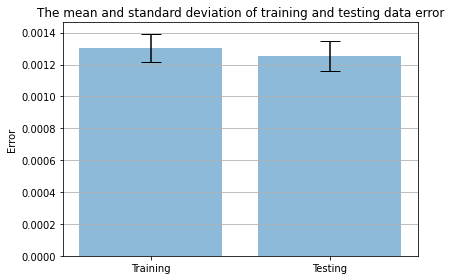

In [12]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()